# Pytorch 快速使用手册

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ["CUDA_VISIBLE_DEVICES"] ="2"
import torch
import torch.nn as nn

print(torch.__version__)


1.2.0+cpu


## 查看是否有GPU

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") ##判断是否有gpu
import torch.backends.cudnn as cudnn
if torch.cuda.is_available():
    cudnn.benchmark = True

    
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True
    #tf.set_random_seed(seed)
seed_everything(2019)


## 基本命令

In [8]:
x = torch.randn(2,3,224,224)
print(x.size(),x.type())
y = torch.randn(2,3,224,224)
z = x+y

print(z.size(),z.type())
print(y.add_(x).size())
print(y[1,1,1,:2])


torch.Size([2, 3, 224, 224]) torch.FloatTensor
torch.Size([2, 3, 224, 224]) torch.FloatTensor
torch.Size([2, 3, 224, 224])
tensor([ 0.1459, -2.1029])


### torch.Tensor与numpy相互转化

In [14]:
# torch.Tensor ->numpy
a = torch.ones(5)
print("a:",a.size(),type(a))
b = a.numpy()
print('b:',b.shape,type(b))

# numpy ->torch.Tensor
e=torch.from_numpy(b)
print('b',type(b))
print('e',type(e))

a: torch.Size([5]) <class 'torch.Tensor'>
b: (5,) <class 'numpy.ndarray'>
b <class 'numpy.ndarray'>
e <class 'torch.Tensor'>


### torch.Tensor与cuda相互转化

In [16]:
# torch.Tensor ->cuda 
x = torch.randn(2,3,224,224)
y = torch.randn(2,3,224,224)
if torch.cuda.is_available():
    x = x.cuda()
    x = x.to(device)
    y = y.cuda()
    x + y

# cuda->torch.Tensor 
b = x.cpu()
c = y.cpu()

### torch.Tensor与Variable相互转化

In [15]:
# torch.Tensor ->Variable
from torch.autograd import Variable
x = torch.randn(2,3,224,224)
y = Variable(x)
print('y:',type(y),y.size(),y.type())

# Variable -> torch.Tensor
c=y.data#通过 Variable.data 方法相当于将Variable中的torch.tensor 取出来
print('c:',c.type(),c.shape)


y: <class 'torch.Tensor'> torch.Size([2, 3, 224, 224]) torch.FloatTensor
c: torch.FloatTensor torch.Size([2, 3, 224, 224])


### numpy与list相互转化

In [19]:
#  numpy -> list
import numpy as np
d = np.random.random((2,4))
f1=d.tolist()
f2=list(d)

# list -> numpy
g=np.asarray(f2)
g=np.array(f2)
print('f1:',type(f1))
print('g:',type(g))


f1: <class 'list'>
g: <class 'numpy.ndarray'>


### long,int,double,float,byte类型转化

In [21]:

x = torch.randn(2,3,32,32)
print(x.type())
y = x.float()
print("float:",y.type())
y = x.long()
print("long:",y.type())
y = x.int()
print("int:",y.type())
y = x.double()
print("double:",y.type())
y = x.byte()
print("byte:",y.type())

# # 一般只要在Tensor后加long(), int(), double(),float(),byte()等函数就能将Tensor进行类型转换；
# 例如：Torch.LongTensor--->Torch.FloatTensor, 直接使用data.float()即可

torch.FloatTensor
float: torch.FloatTensor
long: torch.LongTensor
int: torch.IntTensor
double: torch.DoubleTensor
byte: torch.ByteTensor


### Autograd: 自动求导

In [22]:
x = Variable(torch.ones(2, 2), requires_grad=True)
print("x =", x)
y = x + 2
print("x + 2 =", y)
print("(x + 2) grad_fn", y.grad_fn)
print("x grad_fn",x.grad_fn)

x = tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
x + 2 = tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)
(x + 2) grad_fn <AddBackward0 object at 0x7fe24c70eb70>
x grad_fn None


In [24]:
z = y * y * 3
out = z.mean()

print(z, out)
out.backward() ## out最好是标量
## out = z
## out.backward(torch.ones(out.shape))
print("x grad=", x.grad)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)
x grad= tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


### [contiguous](https://zhuanlan.zhihu.com/p/64551412)

contiguous 本身是形容词，表示连续的，关于 contiguous,
PyTorch 提供了is_contiguous、contiguous(形容词动用)两个方法,
分别用于判定Tensor是否是 contiguous 的，以及保证Tensor是contiguous的.

is_contiguous直观的解释是**Tensor底层一维数组元素的存储顺序与Tensor按行优先一维展开的元素顺序是否一致**。

Tensor多维数组底层实现是使用一块连续内存的1维数组（行优先顺序存储).
(如transpose、permute、narrow、expand)与原Tensor是共享内存中的数据，
不会改变底层数组的存储，但原来在语义上相邻、内存里也相邻的元素在执行这样的操作后，
在语义上相邻，但在内存不相邻，即不连续了(is not contiguous).

* torch.view等方法操作需要连续的Tensor.

transpose,permute 操作虽然没有修改底层一维数组，
但是新建了一份Tensor元信息，并在新的元信息中的 重新指定 
stride。torch.view 方法约定了不修改数组本身，只是使用新的
形状查看数据。如果我们在 transpose、permute 操作后执行 view.

In [ ]:
t = torch.arange(12).reshape(3,4)
print("t:",t)
print("t.stride:", t.stride())
t2 = t.transpose(0,1)
print("t.transpose:",t2)
print("t.transpose.stride:", t2.stride())
assert t.data_ptr() == t2.data_ptr() # 底层数据是同一个一维数组
t.is_contiguous(),t2.is_contiguous() # t连续，t2不连续

## 搭建数据集

In [ ]:
class Segmentation(object):
    def __init__(self, root, mode=None,shuffle=True, transform=None):
        super(Segmentation, self).__init__()

        self.images, self.masks = _get_pairs(root, mode,shuffle)
        self.mode = mode
        self.transform = transform
        self.shuffle = shuffle
        self.num_class = 5

    def __getitem__(self, index):

        img = cv2.imread(self.images[index])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index],-1)
        # general resize, normalize and to Tensor
        if self.transform is not None:
            img = self.transform(img)

        return torch.FloatTensor(img), torch.LongTensor(mask)

    def __len__(self):
        return len(self.images)

    @property
    def pred_offset(self):
        return 1

    @property
    def classes(self):
        """Category names."""
        return ("0","1","2","3","4")

def _get_pairs(folder, mode='train', shuffle=True):

    if mode == 'train':
        img_folder = os.path.join(folder, '%d_imgs'%crop_size)
        mask_folder = os.path.join(folder, '%d_label'%crop_size)
    else:
        img_folder = os.path.join(folder, '%d_imgs_val'%crop_size)
        mask_folder = os.path.join(folder, '%d_label_val'%crop_size)

    img_paths = glob(img_folder+"/*")
    mask_paths = glob(mask_folder + "/*")
    if shuffle:
        img_paths = np.array(img_paths)
        mask_paths = np.array(mask_paths)
        index = [i for i in range(len(img_paths))]
        np.random.shuffle(index)
        img_paths = img_paths[index]
        mask_paths = mask_paths[index]

    return img_paths, mask_paths

# dataset and dataloader
input_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.2676, 0.2676, 0.2676], [0.180, 0.180, 0.180]),
])
data_kwargs = {'transform': input_transform}
train_dataset = Segmentation("../zz", mode='train',shuffle=True,**data_kwargs)
val_dataset = Segmentation("../zz", mode='val',shuffle=False,**data_kwargs)
print("train_dataset :",len(train_dataset))
print("val_dataset:",len(val_dataset))
train_loader = data.DataLoader(dataset = train_dataset, batch_size= batch_size)
val_loader = data.DataLoader(dataset = val_dataset, batch_size= batch_size)


### [Dataload的注意事项](https://zhuanlan.zhihu.com/p/66145913)

在训练神经网络的时候，大部分时间都是在从磁盘中读取数据，而不是做 Backpropagation．

这种症状的体现是使用 Nividia-smi 查看 GPU 使用率时，Memory-Usage 占用率很高，
但是 GPU-Util 时常为 0%.解决方案下：

In [ ]:
from torch.utils.data import DataLoader


class data_prefetcher():
    def __init__(self, loader):
        self.loader = iter(loader)
        self.stream = torch.cuda.Stream()
        self.mean = torch.tensor([0.485 * 255, 0.456 * 255, 0.406 * 255]).cuda().view(1,3,1,1)
        self.std = torch.tensor([0.229 * 255, 0.224 * 255, 0.225 * 255]).cuda().view(1,3,1,1)
        # With Amp, it isn't necessary to manually convert data to half.
        # if args.fp16:
        #     self.mean = self.mean.half()
        #     self.std = self.std.half()
        self.preload()

    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loader)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(non_blocking=True)
            self.next_target = self.next_target.cuda(non_blocking=True)
            # With Amp, it isn't necessary to manually convert data to half.
            # if args.fp16:
            #     self.next_input = self.next_input.half()
            # else:
            self.next_input = self.next_input.float()
            self.next_input = self.next_input.sub_(self.mean).div_(self.std)

            
train_loader = DataLoader( train_dataset, batch_size=args.batch_size,  shuffle=(train_sampler is None),
        num_workers=args.workers, pin_memory=True,  sampler=train_sampler, collate_fn=fast_collate)
        
prefetcher = data_prefetcher(train_loader)
data, label = prefetcher.next()
iteration = 0
while data is not None:
    iteration += 1
    # 训练代码
    data, label = prefetcher.next()

## 搭建网络

In [26]:
import torch
from torch.autograd import Variable
import torch.nn 
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5*5 square convolution
        # kernel

        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def weights_init(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.normal_(module.weight, mean = 0, std = 1)
                nn.init.constant_(module.bias, 0)
    
model = Net()
print(model)
model.weights_init()
for module in model.modules():
    if isinstance(module, nn.Conv2d):
        weights = module.weight
        weights = weights.reshape(-1).detach().cpu().numpy()
        print(module.bias)                                       # Bias to zero
        plt.hist(weights)
        plt.show()

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [9]:
from collections import OrderedDict
import torch                     # basic tensor functions
import torch.nn as nn            # everything neural network

# Simple sequential model with named layers
layers = OrderedDict([
    ("conv1", nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5)),
    ("relu1", nn.ReLU()),
    ("conv2", nn.Conv2d(20,64,5)),
    ("relu2", nn.ReLU()),
    ("aavgp", nn.AdaptiveAvgPool2d(1)),
])
model = nn.Sequential(layers)
model

Sequential(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(20, 64, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (aavgp): AdaptiveAvgPool2d(output_size=1)
)

### modules() vs children()

In [3]:
class myNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.convBN =  nn.Sequential(nn.Conv2d(10,10,3), nn.BatchNorm2d(10))
        self.linear =  nn.Linear(10,2)

    def forward(self, x):
        pass

Net = myNet()
# Net = myNet().half() ## 指定模型为半精度运行

print("Printing children\n------------------------------")
print(list(Net.children()))
print("\n\nPrinting Modules\n------------------------------")
print(list(Net.modules()))

Printing children
------------------------------
[Sequential(
  (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
), Linear(in_features=10, out_features=2, bias=True)]


Printing Modules
------------------------------
[myNet(
  (convBN): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear): Linear(in_features=10, out_features=2, bias=True)
), Sequential(
  (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
), Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1)), BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), Linear(in_features=10, out_features=2, bias=True)]


### 打印网络信息

In [4]:
for x in Net.named_modules():
  print(x[0], x[1], "\n-------------------------------")

 myNet(
  (convBN): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear): Linear(in_features=10, out_features=2, bias=True)
) 
-------------------------------
convBN Sequential(
  (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
) 
-------------------------------
convBN.0 Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1)) 
-------------------------------
convBN.1 BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 
-------------------------------
linear Linear(in_features=10, out_features=2, bias=True) 
-------------------------------


### 不同的层设置不同的学习率

In [ ]:
class myNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10,5)
        self.fc2 = nn.Linear(5,2)

    def forward(self, x):
        return self.fc2(self.fc1(x))

Net = myNet()
# optimiser = torch.optim.SGD(Net.parameters(), lr = 0.5)

#######################################################################################################
optimiser = torch.optim.SGD([{"params": Net.fc1.parameters(), 'lr' : 0.001, "momentum" : 0.99},
                             {"params": Net.fc2.parameters()}], lr = 0.01, momentum = 0.9)


#######################################################################################################
params_bias = []
params_wts = []
# seperate the bias and weights parameters
for name, parameter in Net.named_parameters():
  if "bias" in name:
    params_bias.append(parameter)
  elif "weight" in name:
    params_wts.append(parameter)

# Set the optimiser to have different hyperparameters for bias and weights
optimiser = torch.optim.SGD([{"params": params_bias, 'lr' : 0.001, "momentum" : 0.99},
                             {"params": params_wts}], lr = 0.01, momentum = 0.9)

## 获得网络信息

### 保存和加载网络模型

In [ ]:
torch.save(Net, "net.pth")
Net = torch.load("net.pth")
print(Net)

# Save and load only the model parameters (recommended).
torch.save(resnet.state_dict(), 'params.ckpt')
resnet.load_state_dict(torch.load('params.ckpt'))

### 获得网络的权重信息


In [30]:
model_dict = net.state_dict()
for k,v in model_dict.items():
    print("layer:",k,v.size())

layer: conv1.weight torch.Size([6, 1, 5, 5])
layer: conv1.bias torch.Size([6])
layer: conv2.weight torch.Size([16, 6, 5, 5])
layer: conv2.bias torch.Size([16])
layer: fc1.weight torch.Size([120, 400])
layer: fc1.bias torch.Size([120])
layer: fc2.weight torch.Size([84, 120])
layer: fc2.bias torch.Size([84])
layer: fc3.weight torch.Size([10, 84])
layer: fc3.bias torch.Size([10])


### 加载网络预训练权重模型

In [31]:
def load_pretrainedweights(model, pretrained_model):
    model_dict = model.state_dict()
    pretrained_dict = torch.load(pretrained_model)
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    return model

load_pretrainedweights(model,pretrained_model="model.ckpt")

### 检查模型是否正确加载权重

In [ ]:
def check_weight_loaded( ):

    model =  EfficientNet_B4()
    model_dict_v1 = model.state_dict()
    model =  EfficientNet_B4()
    model_dict_v2 = model.state_dict()
    for k in model_dict_v1.keys():
        try:
            assert model_dict_v1[k].data.numpy().all() == model_dict_v2[k].data.numpy().all()
        except AssertionError as e:
            print("failed to load weights!")
            break
    else:
        print("--> model weight loading is  successful!")


### 模型权重初始化

In [ ]:
import  torch.nn from init
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv')!="-1":
        init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear')!="-1":
        init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d')!="-1":
        init.normal(m.weight.data, 1.0, 0.02)
        init.constant(m.bias.data, 0.0)
        
model.apply(weights_init_normal)

### 加载网络模型

In [ ]:
model.load_state_dict(torch.load(weight_path, map_location=lambda storage, loc: storage))
model.load_state_dict(torch.load(weight_path, map_location='cpu'))
model = model.module#才是你的模型            

### 获得网络的中间某一层的输出和参数量


In [33]:
print(net)
from torchsummary import summary
summary(net,(1,32,32))

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Linear-3                  [-1, 120]          48,120
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB

### 数据并行

In [38]:
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
print("model parameters device:", next(model.parameters()).is_cuda)

## 迁移学习

In [ ]:
# Download and load the pretrained ResNet-18.
from torchvision.models import resnet18

resnet = resnet18(pretrained=True)
# If you want to finetune only the top layer of the model, set as below.
for param in resnet.parameters():
    param.requires_grad = False

# Replace the top layer for finetuning.
resnet.fc = nn.Linear(resnet.fc.in_features, 100)  # 100 is an example.

# Forward pass.
images = torch.randn(64, 3, 224, 224)
outputs = resnet(images)
print (outputs.size())     # (64, 100)

## hook

由于pytorch会自动舍弃图计算的中间结果，所以想要获取这些数值就需要使用钩子函数。
钩子函数包括Variable的钩子和nn.Module钩子，用法相似。

### register_hook

In [ ]:
import torch
from torch.autograd import Variable

grad_list = []
def print_grad(grad):
    grad_list.append(grad)

x = Variable(torch.ones(2, 1), requires_grad=True)
y = x + 2
z = torch.mean(torch.pow(y, 2))
lr = 1e-3
hook = y.register_hook(print)
# y.register_hook(print_grad)
z.backward()
x.data -= lr * x.grad.data
print(grad_list)
hook.remove()

In [5]:
import torch 
import torch.nn as nn

def hook_fn(m, i, o):
    print(m)
    print("------------Input Grad------------")

    for grad in i:
        try:
            print(grad.shape)
        except AttributeError: 
            print ("None found for Gradient")

    print("------------Output Grad------------")
    for grad in o:  
        try:
            print(grad.shape)
        except AttributeError: 
            print ("None found for Gradient")
    print("\n")

class myNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3,10,2, stride = 2)
        self.relu = nn.ReLU()
        self.flatten = lambda x: x.view(-1)
        self.fc1 = nn.Linear(160,5)
   
  
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.fc1(self.flatten(x))

net = myNet()

net.conv.register_backward_hook(hook_fn)
net.fc1.register_backward_hook(hook_fn)
inp = torch.randn(1,3,8,8)
out = net(inp)
(1 - out.mean()).backward()

Linear(in_features=160, out_features=5, bias=True)
------------Input Grad------------
torch.Size([5])
torch.Size([5])
------------Output Grad------------
torch.Size([5])


Conv2d(3, 10, kernel_size=(2, 2), stride=(2, 2))
------------Input Grad------------
None found for Gradient
torch.Size([10, 3, 2, 2])
torch.Size([10])
------------Output Grad------------
torch.Size([1, 10, 4, 4])




In [8]:
visualisation = {}

inp = torch.randn(1,3,8,8)

def hook_fn(m, i, o):
    visualisation[m] = o 

net = myNet()

for name, layer in net._modules.items():
    layer.register_forward_hook(hook_fn)

out = net(inp) 

## [常用的损失函数](https://github.com/CoinCheung/pytorch-loss)

In [37]:

def dice_loss(logits,true, eps=1e-7):
    """Computes the Sørensen–Dice loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss.
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)


criterion = nn.CrossEntropyLoss().to(device)
criterion = nn.BCELoss().to(device)
criterion = dice_loss

In [ ]:
import torch.nn as nn
import torch.optim as optim

class CriterionWithLabelSmoothing(nn.Module):
    
    def __init__(self, criterion, alpha=0.2):
        super(CriterionWithLabelSmoothing, self).__init__()
        self.criterion = criterion
        if self.criterion.reduction != 'none':
            raise ValueError("Input criterion should have reduction equal none")
        self.alpha = alpha
    
    def forward(self, logits, targets):
        loss = self.criterion(logits, targets)
        log_probs = torch.log_softmax(logits, dim=1)
        klloss = -log_probs.mean(dim=1)        
        out = (1.0 - self.alpha) * loss + self.alpha * klloss
        return out.mean(dim=0)

def get_criterion(alpha):
    return CriterionWithLabelSmoothing(nn.CrossEntropyLoss(reduction='none'), alpha=0.2)


### OHEM_crossEntropy_loss

In [ ]:
import torch
import torch.nn as nn

class OHEM_crossEntropy_loss(nn.Module):
    def __init__(self, top_k=0.7):
        super(OHEM_crossEntropy_loss, self).__init__()
        self.loss = nn.CrossEntropyLoss(reduction= 'none')
        self.top_k = top_k
    
    def forward(self, logits, targets):
        loss = self.loss(logits, targets)
        valid_loss, idx = torch.topk(loss, int(self.top_k * loss.size()[0]))  
        return torch.mean(valid_loss)

### weights_loss

In [ ]:
## 0,1类更难，设置权重为1.2，2类更容易，设置权重为0.8
weights = [1.2, 1.2, 0.8]
class_weights = torch.FloatTensor(weights).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

### label_smoothing_v1_loss

In [ ]:
import torch.nn as nn
class LabelSmoothSoftmaxCEV1_Loss(nn.Module):

    def __init__(self, lb_smooth=0.1, reduction='mean', lb_ignore=-100):
        super(LabelSmoothSoftmaxCEV1_Loss, self).__init__()
        self.lb_smooth = lb_smooth
        self.reduction = reduction
        self.lb_ignore = lb_ignore
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, logits, label):
        '''
        args: logits: tensor of shape (N, C, H, W)
        args: label: tensor of shape(N, H, W)
        '''
        # overcome ignored label
        with torch.no_grad():
            num_classes = logits.size(1)
            label = label.clone().detach()
            ignore = label == self.lb_ignore
            n_valid = (ignore == 0).sum()
            label[ignore] = 0
            lb_pos, lb_neg = 1. - self.lb_smooth, self.lb_smooth / num_classes
            label = torch.empty_like(logits).fill_(
                lb_neg).scatter_(1, label.unsqueeze(1), lb_pos).detach()

        logs = self.log_softmax(logits)
        loss = -torch.sum(logs * label, dim=1)
        loss[ignore] = 0
        if self.reduction == 'mean':
            loss = loss.sum() / n_valid
        if self.reduction == 'sum':
            loss = loss.sum()

        return loss

### label_smoothing_v2_loss

In [ ]:
class LabelSmoothSoftmaxCEFunction(torch.autograd.Function):

    @staticmethod
    def forward(ctx, logits, label, lb_smooth, reduction, lb_ignore):
        # prepare label
        num_classes = logits.size(1)
        label = label.clone().detach()
        ignore = label == lb_ignore
        n_valid = (ignore == 0).sum()
        label[ignore] = 0
        lb_pos, lb_neg = 1. - lb_smooth, lb_smooth / num_classes
        label = torch.empty_like(logits).fill_(
            lb_neg).scatter_(1, label.unsqueeze(1), lb_pos).detach()

        scores = torch.softmax(logits, dim=1)
        logs = torch.log(scores)

        ctx.scores = scores
        ctx.label = label
        ctx.reduction = reduction
        ctx.n_valid = n_valid

        loss = -torch.sum(logs * label, dim=1)
        loss[ignore] = 0
        if reduction == 'mean':
            loss = loss.sum() / n_valid
        if reduction == 'sum':
            loss = loss.sum()
        return loss

    @staticmethod
    def backward(ctx, grad_output):
        scores = ctx.scores
        label = ctx.label
        reduction = ctx.reduction
        n_valid = ctx.n_valid
        grad = grad_output * (scores - label)
        if reduction == 'mean':
            grad /= n_valid
        return grad, None, None, None, None, None


class LabelSmoothSoftmaxCEV2_losss(nn.Module):

    def __init__(self, lb_smooth=0.1, reduction='mean', lb_ignore=-100):
        super(LabelSmoothSoftmaxCEV2_losss, self).__init__()
        self.lb_smooth = lb_smooth
        self.reduction = reduction
        self.lb_ignore = lb_ignore

    def forward(self, logits, label):
        return LabelSmoothSoftmaxCEFunction.apply(
                logits, label, self.lb_smooth, self.reduction, self.lb_ignore)

### Focal loss

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self,
                 alpha=0.25,
                 gamma=2,
                 reduction='mean',
                 ignore_lb=255):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ignore_lb = ignore_lb
        self.crit = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, logits, label):
        '''
        args: logits: tensor of shape (N, C, H, W)
        args: label: tensor of shape(N, H, W)
        '''
        # overcome ignored label
        with torch.no_grad():
            label = label.clone().detach()
            ignore = label == self.ignore_lb
            n_valid = (ignore == 0).sum()
            label[ignore] = 0
            lb_one_hot = torch.zeros_like(logits).scatter_(
                1, label.unsqueeze(1), 1).detach()
            alpha = torch.empty_like(logits).fill_(1 - self.alpha)
            alpha[lb_one_hot == 1] = self.alpha

        # compute loss
        probs = torch.sigmoid(logits)
        pt = torch.where(lb_one_hot == 1, probs, 1 - probs)
        ce_loss = self.crit(logits, lb_one_hot)
        loss = (alpha * torch.pow(1 - pt, self.gamma) * ce_loss).sum(dim=1)
        loss[ignore == 1] = 0
        if self.reduction == 'mean':
            loss = loss.sum() / n_valid
        if self.reduction == 'sum':
            loss = loss.sum()
        return loss

### Dual_Focal loss

In [ ]:
class Dual_Focal_loss(nn.Module):
    '''
    This loss is proposed in this paper: https://arxiv.org/abs/1909.11932
    It does not work in my projects, hope it will work well in your projects.
    Hope you can correct me if there are any mistakes in the implementation.
    '''

    def __init__(self, ignore_lb=255, eps=1e-5, reduction='mean'):
        super(Dual_Focal_loss, self).__init__()
        self.ignore_lb = ignore_lb
        self.eps = eps
        self.reduction = reduction
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, logits, label):
        ignore = label.data.cpu() == self.ignore_lb
        n_valid = (ignore == 0).sum()
        label = label.clone()
        label[ignore] = 0
        lb_one_hot = logits.data.clone().zero_().scatter_(1, label.unsqueeze(1), 1).detach()

        pred = torch.softmax(logits, dim=1)
        loss = -torch.log(self.eps + 1. - self.mse(pred, lb_one_hot)).sum(dim=1)
        loss[ignore] = 0
        if self.reduction == 'mean':
            loss = loss.sum() / n_valid
        elif self.reduction == 'sum':
            loss = loss.sum()
        elif self.reduction == 'none':
            loss = loss
        return loss

### Dice loss

In [ ]:
class GeneralizedSoftDiceLoss(nn.Module):
    def __init__(self,
                 p=1,
                 smooth=1,
                 reduction='mean',
                 weight=None,
                 ignore_lb=255):
        super(GeneralizedSoftDiceLoss, self).__init__()
        self.p = p
        self.smooth = smooth
        self.reduction = reduction
        self.weight = None if weight is None else torch.tensor(weight)
        self.ignore_lb = ignore_lb

    def forward(self, logits, label):
        '''
        args: logits: tensor of shape (N, C, H, W)
        args: label: tensor of shape(N, H, W)
        '''
        # overcome ignored label
        ignore = label.data.cpu() == self.ignore_lb
        label = label.clone()
        label[ignore] = 0
        lb_one_hot = torch.zeros_like(logits).scatter_(1, label.unsqueeze(1), 1)
        ignore = ignore.nonzero()
        _, M = ignore.size()
        a, *b = ignore.chunk(M, dim=1)
        lb_one_hot[[a, torch.arange(lb_one_hot.size(1)).long(), *b]] = 0
        lb_one_hot = lb_one_hot.detach()

        # compute loss
        probs = torch.sigmoid(logits)
        numer = torch.sum((probs*lb_one_hot), dim=(2, 3))
        denom = torch.sum(probs.pow(self.p)+lb_one_hot.pow(self.p), dim=(2, 3))
        if not self.weight is None:
            numer = numer * self.weight.view(1, -1)
            denom = denom * self.weight.view(1, -1)
        numer = torch.sum(numer, dim=1)
        denom = torch.sum(denom, dim=1)
        loss = 1 - (2*numer+self.smooth)/(denom+self.smooth)

        if self.reduction == 'mean':
            loss = loss.mean()
        return loss


class BatchSoftDiceLoss(nn.Module):
    def __init__(self,
                 p=1,
                 smooth=1,
                 weight=None,
                 ignore_lb=255):
        super(BatchSoftDiceLoss, self).__init__()
        self.p = p
        self.smooth = smooth
        self.weight = None if weight is None else torch.tensor(weight)
        self.ignore_lb = ignore_lb

    def forward(self, logits, label):
        '''
        args: logits: tensor of shape (N, C, H, W)
        args: label: tensor of shape(N, H, W)
        '''
        # overcome ignored label
        ignore = label.data.cpu() == self.ignore_lb
        label = label.clone()
        label[ignore] = 0
        lb_one_hot = torch.zeros_like(logits).scatter_(1, label.unsqueeze(1), 1)
        ignore = ignore.nonzero()
        _, M = ignore.size()
        a, *b = ignore.chunk(M, dim=1)
        lb_one_hot[[a, torch.arange(lb_one_hot.size(1)).long(), *b]] = 0
        lb_one_hot = lb_one_hot.detach()

        # compute loss
        probs = torch.sigmoid(logits)
        numer = torch.sum((probs*lb_one_hot), dim=(2, 3))
        denom = torch.sum(probs.pow(self.p)+lb_one_hot.pow(self.p), dim=(2, 3))
        if not self.weight is None:
            numer = numer * self.weight.view(1, -1)
            denom = denom * self.weight.view(1, -1)
        numer = torch.sum(numer)
        denom = torch.sum(denom)
        loss = 1 - (2*numer+self.smooth)/(denom+self.smooth)
        return loss

In [ ]:
import torch
import torch.nn as nn
 
class DiceLoss(nn.Module):
	def __init__(self):
		super(DiceLoss, self).__init__()
 
	def	forward(self, input, target):
		N = target.size(0)
		smooth = 1
 
		input_flat = input.view(N, -1)
		target_flat = target.view(N, -1)
 
		intersection = input_flat * target_flat
 
		loss =  (2 * intersection.sum(1) + smooth) / (input_flat.sum(1) + target_flat.sum(1) + smooth)
		loss = 1 - loss.sum() / N
 
		return loss
 
class MulticlassDiceLoss(nn.Module):
	"""
	requires one hot encoded target. Applies DiceLoss on each class iteratively.
	requires input.shape[0:1] and target.shape[0:1] to be (N, C) where N is
	  batch size and C is number of classes
	"""
	def __init__(self):
		super(MulticlassDiceLoss, self).__init__()
 
	def forward(self, input, target, weights=None):
 
		C = target.shape[1]
 
		# if weights is None:
		# 	weights = torch.ones(C) #uniform weights for all classes
 
		dice = DiceLoss()
		totalLoss = 0
 
		for i in range(C):
			diceLoss = dice(input[:,i], target[:,i])
			if weights is not None:
				diceLoss *= weights[i]
			totalLoss += diceLoss
 
		return totalLoss

def IOU(pred , mask):
    N = mask.size(0)
    eps=1e-6
    input_flat = pred.view(N, -1)
    target_flat = mask.view(N, -1)
    intersection = input_flat * target_flat
    iou = (intersection.sum(1) + eps) / (input_flat.sum(1) + target_flat.sum(1)-intersection.sum(1) + eps)
    return iou.mean()

### AMSoftmax loss

In [ ]:
class AMSoftmax(nn.Module):
    def __init__(self,
                 in_feats,
                 n_classes=10,
                 m=0.3,
                 s=15):
        super(AMSoftmax, self).__init__()
        self.m = m
        self.s = s
        self.in_feats = in_feats
        self.W = torch.nn.Parameter(torch.randn(in_feats, n_classes), requires_grad=True)
        self.ce = nn.CrossEntropyLoss()
        nn.init.xavier_normal_(self.W, gain=1)

    def forward(self, x, lb):
        assert x.size()[0] == lb.size()[0]
        assert x.size()[1] == self.in_feats
        x_norm = torch.norm(x, p=2, dim=1, keepdim=True).clamp(min=1e-12)
        x_norm = torch.div(x, x_norm)
        w_norm = torch.norm(self.W, p=2, dim=0, keepdim=True).clamp(min=1e-12)
        w_norm = torch.div(self.W, w_norm)
        costh = torch.mm(x_norm, w_norm)
        lb_view = lb.view(-1, 1)
        if lb_view.is_cuda: lb_view = lb_view.cpu()
        delt_costh = torch.zeros(costh.size()).scatter_(1, lb_view, self.m)
        if x.is_cuda: delt_costh = delt_costh.cuda()
        costh_m = costh - delt_costh
        costh_m_s = self.s * costh_m
        loss = self.ce(costh_m_s, lb)
        return loss


criteria = AMSoftmax(1024, 10)
a = torch.randn(20, 1024)
lb = torch.randint(0, 10, (20, ), dtype=torch.long)
loss = criteria(a, lb)
loss.backward()

print(loss.detach().numpy())
print(list(criteria.parameters())[0].shape)
print(type(next(criteria.parameters())))

### mixup

In [ ]:
## https://github.com/facebookresearch/mixup-cifar10/blob/master/train.py

def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)




inputs, targets = inputs.cuda(), targets.cuda()
inputs, targets_a, targets_b, lam = mixup_data(inputs, targets,args.alpha, use_cuda)
inputs, targets_a, targets_b = map(Variable, (inputs,targets_a, targets_b))
outputs = net(inputs)
loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
train_loss += loss.data[0]
_, predicted = torch.max(outputs.data, 1)
total += targets.size(0)
correct += (lam * predicted.eq(targets_a.data).cpu().sum().float()
            + (1 - lam) * predicted.eq(targets_b.data).cpu().sum().float())

### NLLLoss和CrossEntropyLoss(Softmax–>Log–>NLLLoss)

In [1]:
import torch
import torch.nn as nn
x=torch.randn(4,3)
print("x:", x)
sm = nn.Softmax(dim =1)
print("softmax x:", sm(x))
print("log:", torch.log(sm(x)))

loss = nn.NLLLoss()
target = torch.tensor([0,2,1,1])
print("target type:",target.type())
print("pred type:",x.type())
print("NLLLoss:",loss(torch.log(sm(x)),target))

loss = nn.CrossEntropyLoss() # Softmax–Log–NLLLoss
print("CrossEntropyLoss :", loss(x, target))

loss = nn.CrossEntropyLoss(reduction= 'none') # Softmax–Log–NLLLoss
print("CrossEntropyLoss :", loss(x, target))

x: tensor([[-0.3314,  0.3583,  0.2077],
        [ 1.4749, -0.0436,  0.2306],
        [ 1.2537,  0.2282, -0.0145],
        [-1.5693,  0.3295,  0.2172]])
softmax x: tensor([[0.2124, 0.4234, 0.3642],
        [0.6635, 0.1453, 0.1912],
        [0.6098, 0.2187, 0.1716],
        [0.0733, 0.4893, 0.4374]])
log: tensor([[-1.5492, -0.8595, -1.0101],
        [-0.4102, -1.9287, -1.6546],
        [-0.4947, -1.5202, -1.7629],
        [-2.6135, -0.7147, -0.8269]])
target type: torch.LongTensor
pred type: torch.FloatTensor
NLLLoss: tensor(1.3597)
CrossEntropyLoss : tensor(1.3597)
CrossEntropyLoss : tensor([1.5492, 1.6546, 1.5202, 0.7147])


### BCELOSS和BCEWithLogitsLoss(Sigmoid->BCELoss)

In [12]:
import torch.nn as nn
x=torch.randn(3,3)
print("x:", x)
sm = nn.Sigmoid()
print("Sigmoid x:", sm(x))


target = torch.FloatTensor([[0,1,1],[1,0,0],[0,1,0]])
loss = nn.BCELoss() # Sigmoid-BCELoss
print("BCELoss :", loss(sm(x), target))

loss = nn.BCEWithLogitsLoss() # Sigmoid-BCELoss
print("CrossEntropyLoss :", loss(x, target))


x: tensor([[-1.1235, -0.0948, -0.8286],
        [ 0.8362, -1.9370,  0.7749],
        [ 1.1140, -0.2855,  1.0280]])
Sigmoid x: tensor([[0.2454, 0.4763, 0.3039],
        [0.6977, 0.1260, 0.6846],
        [0.7529, 0.4291, 0.7365]])
BCELoss : tensor(0.8267)
CrossEntropyLoss : tensor(0.8267)


### examples

In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 1:自定义损失函数
def my_mse_loss(x, y):
    return torch.mean(torch.pow((x - y), 2))

## 2: 继承nn.Mdule
class My_loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, y):
        return torch.mean(torch.pow((x - y), 2))

    


x_train = np.array([[3.3], [4.4], [5.5], [6.71], [6.93], [4.168],
                    [9.779], [6.182], [7.59], [2.167], [7.042],
                    [10.791], [5.313], [7.997], [3.1]], dtype=np.float32)

y_train = np.array([[1.7], [2.76], [2.09], [3.19], [1.694], [1.573],
                    [3.366], [2.596], [2.53], [1.221], [2.827],
                    [3.465], [1.65], [2.904], [1.3]], dtype=np.float32)

# 将numpy数据转化为torch的张量
inputs = torch.from_numpy(x_train)
targets = torch.from_numpy(y_train)

input_size = 1
output_size = 1
num_epochs = 60
learning_rate = 0.001

# 第三步： 构建模型，构建一个一层的网络模型
model = nn.Linear(input_size, output_size)

# 与模型相关的配置、损失函数、优化方式
# 使用自定义函数，等价于criterion = nn.MSELoss()
criterion = My_loss()

# 定义迭代优化算法， 使用的是随机梯度下降算法
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_history = []
# 第四步：训练模型，迭代训练
for epoch in range(num_epochs):
    #  前向传播计算网络结构的输出结果
    outputs = model(inputs)

    # 计算损失函数
    loss = criterion(outputs, targets)

    # 反向传播更新参数，三步策略，归零梯度——>反向传播——>更新参数
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # 打印训练信息和保存loss
    loss_history.append(loss.item())
    if (epoch + 1) % 5 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item()))

Epoch [5/60], Loss: 33.5815
Epoch [10/60], Loss: 13.8363
Epoch [15/60], Loss: 5.8369
Epoch [20/60], Loss: 2.5958
Epoch [25/60], Loss: 1.2825
Epoch [30/60], Loss: 0.7501
Epoch [35/60], Loss: 0.5341
Epoch [40/60], Loss: 0.4463
Epoch [45/60], Loss: 0.4103
Epoch [50/60], Loss: 0.3955
Epoch [55/60], Loss: 0.3891
Epoch [60/60], Loss: 0.3862


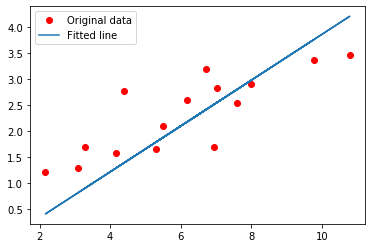

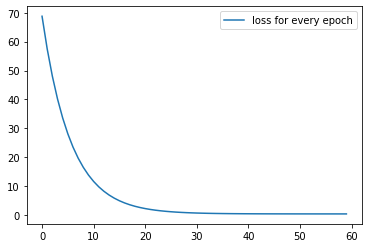

In [5]:
# 第五步：结果展示。画出原y与x的曲线与网络结构拟合后的曲线
predicted = model(torch.from_numpy(x_train)).detach().numpy()  # 模型输出结果

plt.plot(x_train, y_train, 'ro', label='Original data')  # 原始数据
plt.plot(x_train, predicted, label='Fitted line')  # 拟合之后的直线
plt.legend()
plt.show()

# 画loss在迭代过程中的变化情况
plt.plot(loss_history, label='loss for every epoch')
plt.legend()
plt.show()

## 常见的指标

### 分类指标

In [ ]:

predict = output.argmax(dim = 1)
confusion_matrix =torch.zeros(2,2)
for p,t in zip(predict.view(-1), target.view(-1)):
    confusion_matrix[t.long(), p.long()] += 1
a_p =(confusion_matrix.diag() / confusion_matrix.sum(1))[0]
b_p = (confusion_matrix.diag() / confusion_matrix.sum(1))[1]
a_r =(confusion_matrix.diag() / confusion_matrix.sum(0))[0]
b_r = (confusion_matrix.diag() / confusion_matrix.sum(0))[1]


### 语义分割MIOU

In [ ]:
def mIoU_metrics(pred, mask):
    """

    :param pred: (N,C,H,W)
    :param mask:  (N,C,H,W)
    :return: IOU (C)
    """
    N, C, H, W = mask.size()
    eps=1e-6
    input_flat = pred.permute(0, 2, 3, 1).reshape(N * H * W, -1)
    target_flat = mask.permute(0, 2, 3, 1).reshape(N * H * W, -1)
    intersection = input_flat * target_flat
    iou = (intersection.sum(0) + eps) / (input_flat.sum(0) + target_flat.sum(0)-intersection.sum(0) + eps)
    return iou


## 常用的优化器


In [ ]:
optimizer = torch.optim.SGD(model.parameters(),
                                 lr=lr,
                                 momentum=momentum,
                                 weight_decay=weight_decay)

## 常用的学习率

In [ ]:
# lr scheduling
lr_scheduler = WarmupPolyLR(optimizer,
                                 max_iters=epochs * iters_per_epoch,
                                 power=0.9,
                                 warmup_factor=warmup_factor,
                                 warmup_iters=warmup_iters,
                                 warmup_method=warmup_method)

In [ ]:
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimiser, milestones = [10,20], gamma = 0.1)
scheduler.step()

## 训练过程

In [ ]:
def training_loop(weight_dir, results_dir, n_epochs, optimizer, model, loss_fn, trian_dataloader, val_dataloader, model_name, save_best=True, resume = False):
    from tqdm import tqdm
    from collections import deque
    import numpy as np
    import pandas as pd
    
    min_loss = 1e10
    
    train_history = []
    if resume:
        model.load_state_dict(torch.load("./%s/%s.pt" % (weight_dir, model_name)))
        pf = pd.read_csv("./%s/%s_history.csv" % (results_dir, model_name))
        train_history = pf.values.tolist()
    
    for epoch in range(1, n_epochs + 1):
    
        model.train()
        train_loss = deque(maxlen=20)
        train_bar = tqdm(enumerate(trian_dataloader))
        for index, (image, label) in train_bar:
            image = image.to(device)
            label = label.to(device)
            model = model.to(device)
    
            train_preds = model(image)
            loss_train = loss_fn(train_preds, label).to(device)
            train_loss.append(loss_train.item())
    
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            train_bar.set_description("Lr:{:.6f},Loss:{:.4f}".format(optimizer.param_groups[0]['lr'], np.mean(train_loss)))
    
        torch.cuda.empty_cache()
        model.eval()
        val_loss = []
        total = 0
        correct = 0
        with torch.no_grad():
            for index, (image, label) in tqdm(enumerate(val_dataloader)):
                image = image.to(device)
                label = label.to(device)
                model = model.to(device)
    
                val_preds = model(image)
                loss_val = loss_fn(val_preds, label).to(device)
                val_loss.append(loss_val.item())
                _, predicted = torch.max(val_preds.data, 1)
                total += label.size(0)
                correct += (predicted == label).sum().item()
        if save_best:
            if np.mean(val_loss) < min_loss:
                min_loss = np.mean(val_loss)
                torch.save(model.state_dict(), "./%s/%s.pt" % (weight_dir, model_name))
    
        print("\nepoch:{:d}/{:d}, Lr:{:.6f},Loss:{:.4f},val_loss:{:.4f},val_accuracy;{:.4f}".
              format(epoch, n_epochs, optimizer.param_groups[0]['lr'], np.mean(train_loss), np.mean(val_loss),
                     (100 * correct / total)))
    
        train_history.append(
            [optimizer.param_groups[0]['lr'], np.mean(train_loss), np.mean(val_loss), train_rmse, (100 * correct / total)])
        x = pd.DataFrame(train_history)
        x.columns = ['lr', 'train_loss', 'val_loss', 'train_accuracy', 'val_accuracy']
        x.to_csv("./%s/%s_history.csv" % (results_dir, model_name), index=False)

### 保持训练记录到csv文件

In [ ]:
import pandas as pd
train_history = np.random.random(1000,6)
x = pd.DataFrame(train_history)
x.columns= ['Loss', 'val_loss', 'val_pixAcc', 'train_pixAcc', 'val_mIoU', 'train_mIoU']
x.to_csv("./checkpoint/%s.csv"%model_name, index=False)

In [ ]:
## 显示gpu
!pip install gputil
from GPUtil import showUtilization as gpu_usage
gpu_usage()

## 模型验证过程

In [ ]:
def model_evaluate(model, val_dataloader, loss_fn):
    from tqdm import tqdm
    with torch.no_grad():
        val_preds = []
        val_loss = [ ]
        total = 0
        correct = 0
        for index,(image,label) in tqdm(enumerate(val_dataloader)):
            image = image.to(device)
            label = label.to(device)
            model = model.to(device)
            
            preds = model(image)
            loss_val = loss_fn(preds, label).to(device)
            
            val_preds.append(preds.cpu().data)
            val_loss.append(loss_val.item())

            _, predicted = torch.max(preds.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
        
        accuracy = correct / total
    
    return val_preds, val_loss, accuracy


In [ ]:
def model_predict(model, test_dataloader):
    from tqdm import tqdm
    with torch.no_grad():
        val_preds = []
        for index,image in tqdm(enumerate(test_dataloader)):
            image = image.to(device)
            model = model.to(device)
            preds = model(image)
            val_preds.append(preds.cpu().data)
    
    return val_preds


# 高级技巧

## GEM
generalized mean pooling，出自Fine-tuning CNN Image Retrieval with No Human Annotation，提出的是一种可学习的pooling layer，可提高检索性能

In [ ]:
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class GeneralizedMeanPooling(nn.Module):
    """Applies a 2D power-average adaptive pooling over an input signal composed of several input planes.
    The function computed is: :math:`f(X) = pow(sum(pow(X, p)), 1/p)`
        - At p = infinity, one gets Max Pooling
        - At p = 1, one gets Average Pooling
    The output is of size H x W, for any input size.
    The number of output features is equal to the number of input planes.
    Args:
        output_size: the target output size of the image of the form H x W.
                     Can be a tuple (H, W) or a single H for a square image H x H
                     H and W can be either a ``int``, or ``None`` which means the size will
                     be the same as that of the input.
    """

    def __init__(self, norm, output_size=1, eps=1e-6):
        super(GeneralizedMeanPooling, self).__init__()
        assert norm > 0
        self.p = float(norm)
        self.output_size = output_size
        self.eps = eps

    def forward(self, x):
        x = x.clamp(min=self.eps).pow(self.p)
        return F.adaptive_avg_pool2d(x, self.output_size).pow(1. / self.p)

    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + str(self.p) + ', ' \
            + 'output_size=' + str(self.output_size) + ')'


class GeneralizedMeanPoolingP(GeneralizedMeanPooling):
    """ Same, but norm is trainable
    """
    def __init__(self, norm=3, output_size=1, eps=1e-6):
        super(GeneralizedMeanPoolingP, self).__init__(norm, output_size, eps)
        self.p = Parameter(torch.ones(1) * norm)

if __name__ == '__main__':
    inp = torch.randn(2, 7, 7)
    pool = GeneralizedMeanPooling(2)
    out = pool(inp) #(2,1,1)
    print(out.shape)

## [BNNeck](https://zhuanlan.zhihu.com/p/61831669)

出自罗浩博士的Bag of Tricks and A Strong Baseline for Deep Person Re-identification
其实就是在feature层和fc layer之间增加一层Batch Normalization layer，然后在retrieval的时候，
使用BN后的feature再做一个l2 norm，也就是retrieval with Cosine distance。


In [ ]:
class res50(torch.nn.Module):
    def __init__(self, num_classes):
        super(res50, self).__init__()
        resnet = resnet50(pretrained=True)
        self.backbone = torch.nn.Sequential(
                        resnet.conv1,
                        resnet.bn1,
                        resnet.relu,
                        resnet.layer1,
                        resnet.layer2,
                        resnet.layer3,
                        resnet.layer4
        )
        self.pool = torch.nn.AdaptiveMaxPool2d(1)
        self.bnneck = nn.BatchNorm1d(2048)
        self.bnneck.bias.requires_grad_(False)  # no shift
        self.classifier = nn.Linear(2048, num_classes, bias=False)
    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x)
        feat = x.view(x.shape[0], -1)
        feat = self.bnneck(feat)
        if not self.training:
            return nn.functional.normalize(feat, dim=1, p=2)
        x = self.classifier(feat)
        return x

## dual pooling

这种是在模型层进行改造的一种小trick了，常见的做法：global max/average pooling + fc layer，这里试concat(global max-pooling, global average pooling) + fc layer，其实就是为了丰富特征层，max pooling更加关注重要的局部特征，而average pooling试更加关注全局的特征。不一定有效，我试过不少次，有效的次数比较少，但不少人喜欢这样用。

In [ ]:
class res18(nn.Module):
    def __init__(self, num_classes):
        super(res18, self).__init__()
        self.base = resnet18(pretrained=True)
        self.feature = nn.Sequential(
            self.base.conv1,
            self.base.bn1,
            self.base.relu,
            self.base.maxpool,
            self.base.layer1,
            self.base.layer2,
            self.base.layer3,
            self.base.layer4
        )
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.reduce_layer = nn.Conv2d(1024, 512, 1)
        self.fc  = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
            )
    def forward(self, x):
        bs = x.shape[0]
        x = self.feature(x)
        x1 = self.avg_pool(x).view(bs, -1)
        x2 = self.max_pool(x).view(bs, -1)
        x1 = self.avg_pool(x)
        x2 = self.max_pool(x)
        x = torch.cat([x1, x2], dim=1)
        x = self.reduce_layer(x).view(bs, -1)
        logits = self.fc(x)
        return logits

## unet的改进

很多top solution都是修改Unet的Decoder，最常见的有如下几种。
* [oc block in deconder](https://github.com/tugstugi/pytorch-saltnet)

* scse block

* Hypercolumn block

* CBAM（Convolutional Block Attention Module，bestfitting比较喜欢用）

* BAM（Bottleneck attention module）

这些注意力block一般是放在decoder不同stage出来的feature后面，因为注意力机制往往都是来优化feature的。

* dual head(multi task learning)，也就是构造一个end2end带有分割与分类的模型。

同时，多任务学习往往会降低模型过拟合的程度，并可以提升模型的性能。